# Make sure run from ipykernel located in segmenteverygrain

### module load cuda11

## Import packages

In [1]:
%matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from skimage.measure import regionprops, regionprops_table
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from tqdm import trange

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-04-03 18:28:44.642871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 18:28:47.582221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os

!export CUDNN_PATH="/home/u4/pjlohr/.conda/envs/segmenteverygrain/lib/python3.8/site-packages/nvidia/cudnn"
!export LD_LIBRARY_PATH="/home/u4/pjlohr/.conda/envs/segmenteverygrain/lib/python3.8/site-packages/nvidia/cudnn/lib:/opt/ohpc/pub/apps/cuda/11.8/lib64/"
!export PATH="/opt/ohpc/pub/apps/cuda/11.8/bin:$PATH"


## Load models

In [6]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.load_weights('/groups/aprintz/github/segmenteverygrain/segmenteverygrain/checkpoints/seg_model');


sam_checkpoint = "/groups/aprintz/github/segmenteverygrain/segmenteverygrain/checkpoints/sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


## Run segmentation

Grains are supposed to be well defined in the image; e.g., if a grain consists of only a few pixels, it is unlikely to be detected.

The segmentation can take a few minutes even for medium-sized images, so do not start with large images (downsample them if necessary). Images with ~2000 pixels along their largest dimension are a good start.

100%|██████████| 225/225 [00:10<00:00, 22.04it/s]
23it [00:00, 155.82it/s]
100%|██████████| 16/16 [00:00<00:00, 171.45it/s]


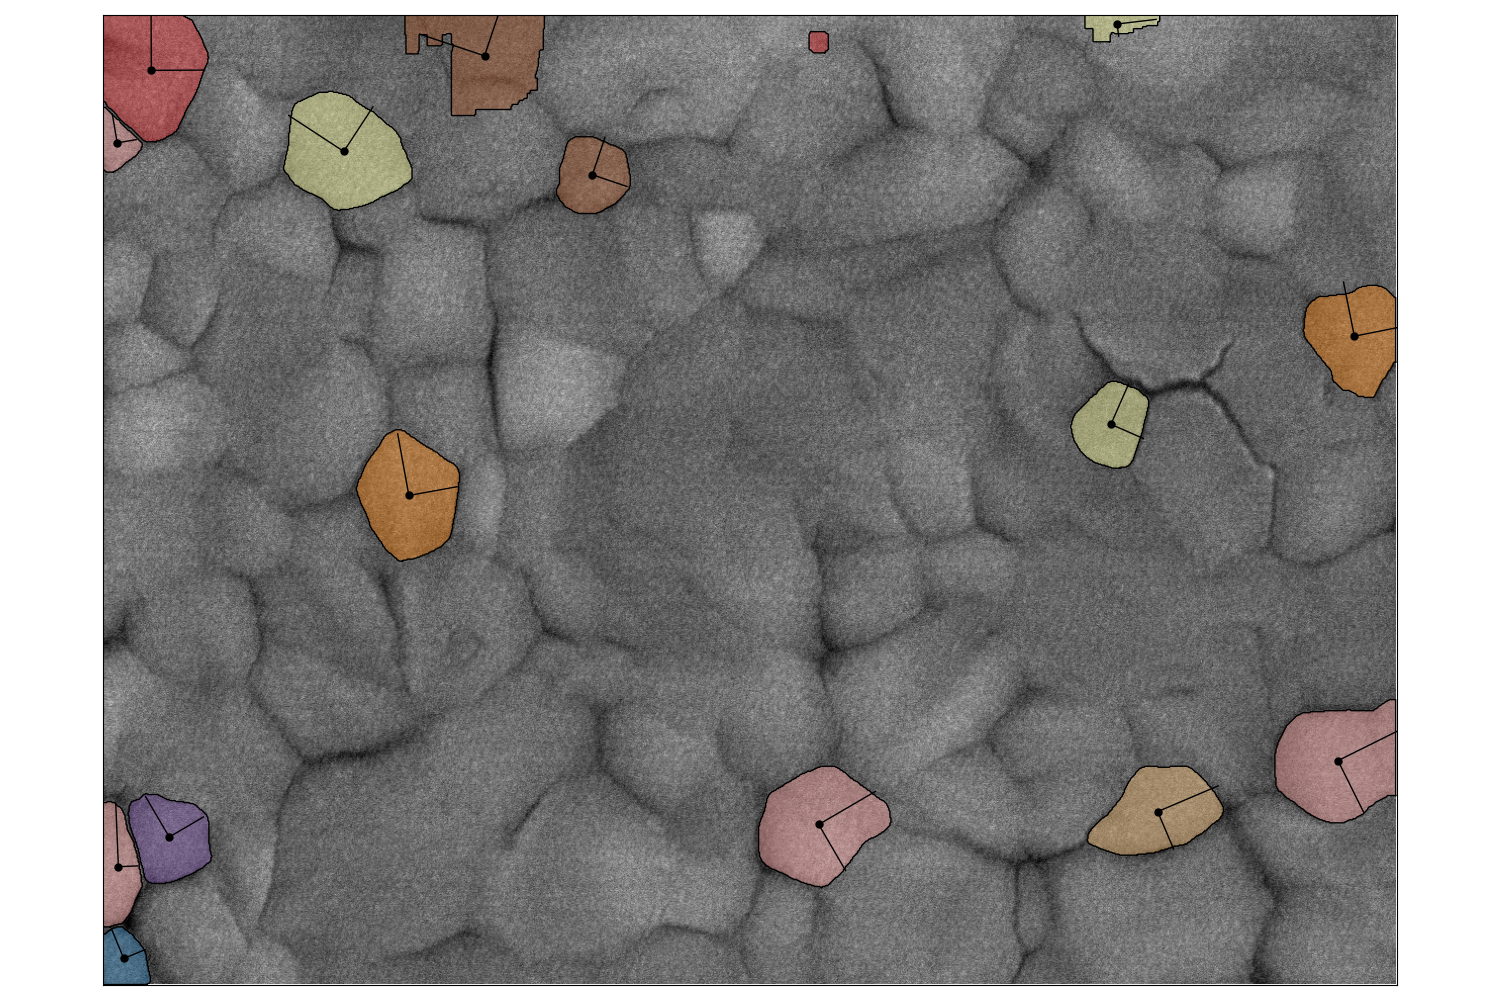

IndexError: list index out of range

IndexError: list index out of range

In [28]:
from PIL import Image, ImageEnhance
import cv2
from matplotlib import pyplot as plt

fname = '/groups/aprintz/github/segmenteverygrain/perovskite_sems/og/Pristine 25KX/231203_AAS_MAPbI3_Ctrl_0cyc_q005.tif'

img = load_img(fname)
width, height = img.size
cropped_img = img.crop((0, 0, width // 2, height // 2)) #top left

enhancer = ImageEnhance.Contrast(cropped_img)
enhanced_img = enhancer.enhance(2.5)  # Increase contrast by a factor of 2.0
# Display the enhanced image
# enhanced_img.show()

big_im = np.array(enhanced_img)

# # print(len(big_im))
big_im_pred = seg.predict_big_image(big_im, model, I=256)

# decreasing the 'dbs_max_dist' parameter results in more SAM prompts (and longer processing times):
labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=1.0) # Unet prediction

# SAM segmentation, using the point prompts from the Unet:
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, 
                                                                         coords, labels, min_area=1000.0)

Use this figure to check the distribution of SAM prompts (= black dots):

In [29]:
# plt.figure(figsize=(15,10))
# plt.imshow(big_im)
# plt.scatter(coords[:,0], coords[:,1], c='k')
# plt.xticks([])
# plt.yticks([]);

## Delete or merge grains in segmentation result
* click on the grain that you want to remove and press the 'x' key
* click on two grains that you want to merge and press the 'm' key (they have to be the last two grains you clicked on)
* press the 'g' key to hide the grain masks (so that you can see the original image better); press the 'g' key again to show the grain masks

In [30]:
grain_inds = []
cid1 = fig.canvas.mpl_connect('button_press_event', 
                              lambda event: seg.onclick2(event, all_grains, grain_inds, ax=ax))
cid2 = fig.canvas.mpl_connect('key_press_event', 
                              lambda event: seg.onpress2(event, all_grains, grain_inds, fig=fig, ax=ax))

Run this cell if you do not want to delete / merge existing grains anymore; it is a good idea to do this before moving on to the next step.

In [31]:
fig.canvas.mpl_disconnect(cid1)
fig.canvas.mpl_disconnect(cid2)

Use this function to update the 'all_grains' list after deleting and merging grains:

100%|██████████| 13/13 [00:00<00:00, 171.77it/s]


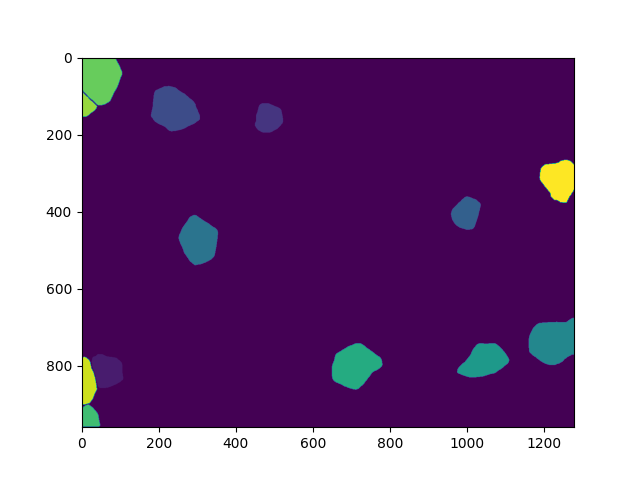

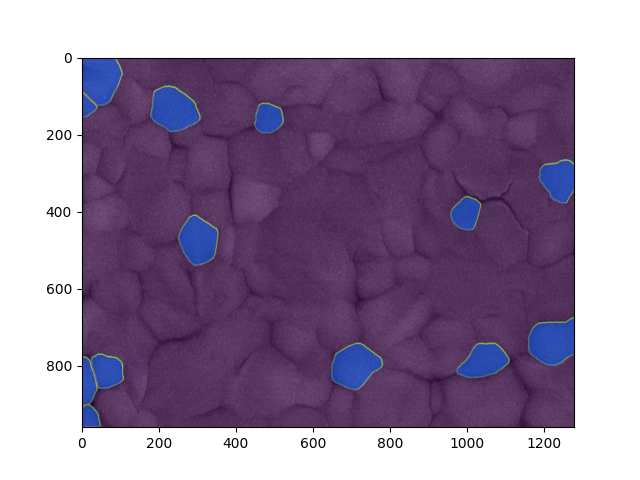

In [33]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

Plot the updated set of grains:

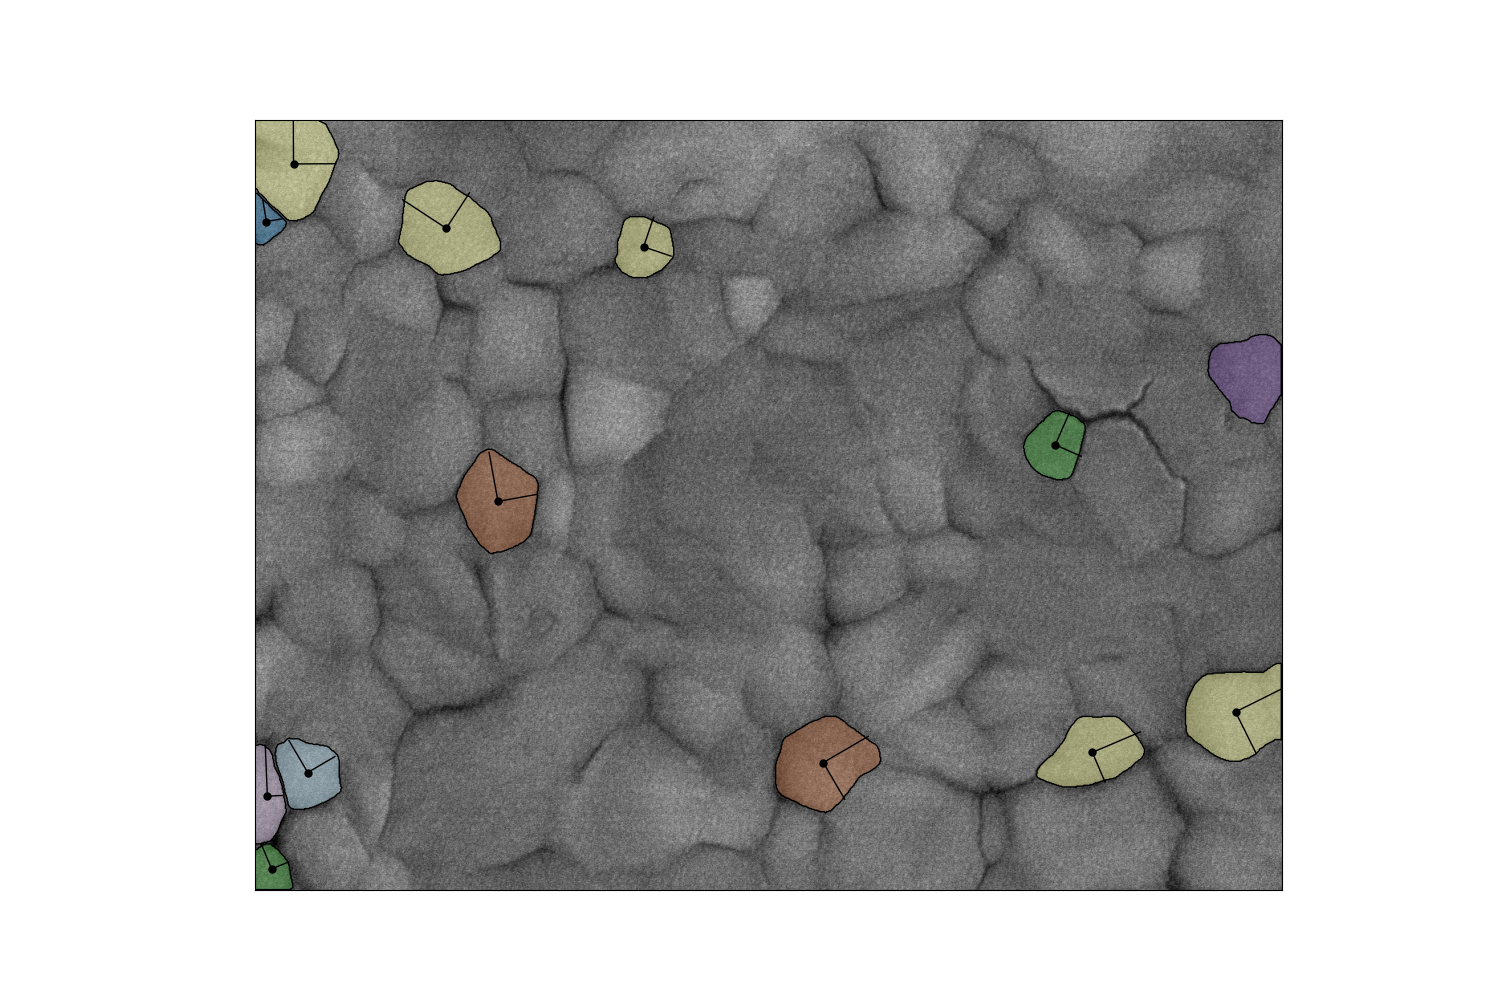

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(big_im)
plt.xticks([])
plt.yticks([])
seg.plot_image_w_colorful_grains(big_im, all_grains, ax, cmap='Paired')
seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)
plt.xlim([0, np.shape(big_im)[1]])
plt.ylim([np.shape(big_im)[0], 0]);

## Add new grains using the Segment Anything Model

* click on unsegmented grain that you want to add
* press the 'x' key if you want to delete the last grain you added
* press the 'm' key if you want to merge the last two grains that you added
* right click outside the grain (but inside the most recent mask) if you want to restrict the grain to a smaller mask - this adds a background prompt

In [35]:
predictor = SamPredictor(sam)
predictor.set_image(big_im) # this can take a while
coords = []
cid3 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.onclick(event, ax, coords, big_im, predictor))
cid4 = fig.canvas.mpl_connect('key_press_event', lambda event: seg.onpress(event, ax, fig))

In [36]:
fig.canvas.mpl_disconnect(cid3)
fig.canvas.mpl_disconnect(cid4)

After you are done with the deletion / addition of grain masks, run this cell to generate an updated set of grains:

100%|██████████| 85/85 [00:00<00:00, 141.63it/s]
/groups/aprintz/github/segmenteverygrain/segmenteverygrain/segmenteverygrain.py:731: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


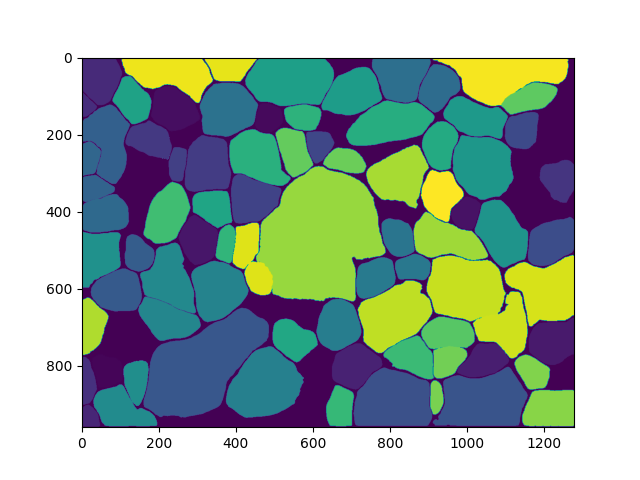

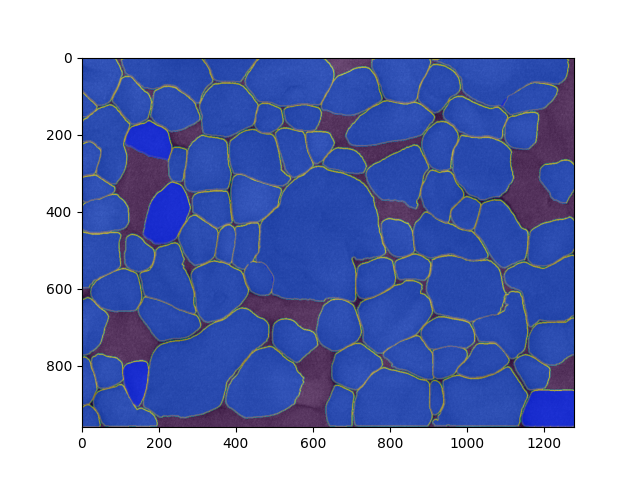

In [37]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

label      area  centroid-0   centroid-1  major_axis_length  \
0       1  0.088608  813.544059    65.257674           0.370015   
1       2  0.069952  158.137466   483.973925           0.312396   
2       3  0.170240  135.041447   237.946429           0.521077   
3       4  0.075664  405.071897   997.216748           0.348057   
4       5  0.149376  475.520030   302.375857           0.495586   
..    ...       ...         ...          ...                ...   
79     81  0.182752  524.743390   440.285764           0.850391   
80     82  0.103152   27.105941   383.372421           0.505702   
81     83  0.280512   42.348734   229.824606           0.997028   
82     84  0.424000   45.835585  1096.847849           1.295887   
83     85  0.160064  355.458916   931.423431           0.513083   

    minor_axis_length  orientation  perimeter  max_intensity-0  \
0            0.314477     0.531293   1.170205            182.0   
1            0.289178    -0.325709   1.000264            160.0   
2            0.422352     0.990970   1.604244            195.0   
3            0.281255    -0.412894   1.056029            147.0   
4            0.387516     0.179298   1.500244            185.0   
..                ...          ...        ...              ...   
79           0.321626     0.287882   2.322871            167.0   
80           0.283844    -1.520975   1.408264            147.0   
81           0.393493     1.407785   2.518518            172.0   
82           0.492345    -1.504561   3.456861            190.0   
83           0.407989     0.043167   1.617499            172.0   

    max_intensity-1  max_intensity-2  mean_intensity-0  mean_intensity-1  \
0             182.0            182.0        113.440592        113.440592   
1             160.0            160.0        103.009378        103.009378   
2             195.0            195.0        111.937970        111.937970   
3             147.0            147.0         97.259251         97.259251   
4             185.0            185.0        107.919880        107.919880   
..              ...              ...               ...               ...   
79            167.0            167.0        103.894064        103.894064   
80            147.0            147.0         98.345587         98.345587   
81            172.0            172.0        101.306012        101.306012   
82            190.0            190.0        112.271623        112.271623   
83            172.0            172.0         99.538585         99.538585   

    mean_intensity-2  min_intensity-0  min_intensity-1  min_intensity-2  
0         113.440592             45.0             45.0             45.0  
1         103.009378             40.0             40.0             40.0  
2         111.937970             37.0             37.0             37.0  
3          97.259251             30.0             30.0             30.0  
4         107.919880             37.0             37.0             37.0  
..               ...              ...              ...              ...  
79        103.894064             35.0             35.0             35.0  
80         98.345587             52.0             52.0             52.0  
81        101.306012             32.0             32.0             32.0  
82        112.271623             47.0             47.0             47.0  
83         99.538585             30.0             30.0             30.0  

[84 rows x 17 columns]

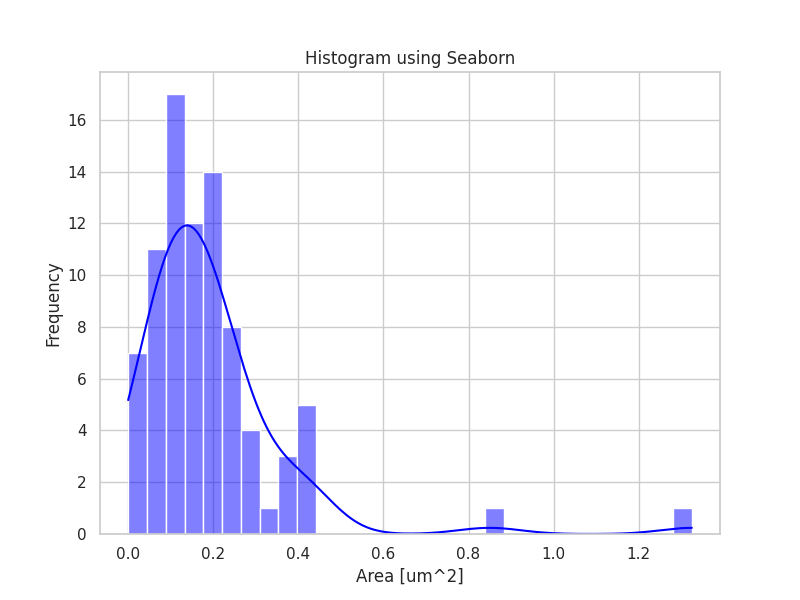

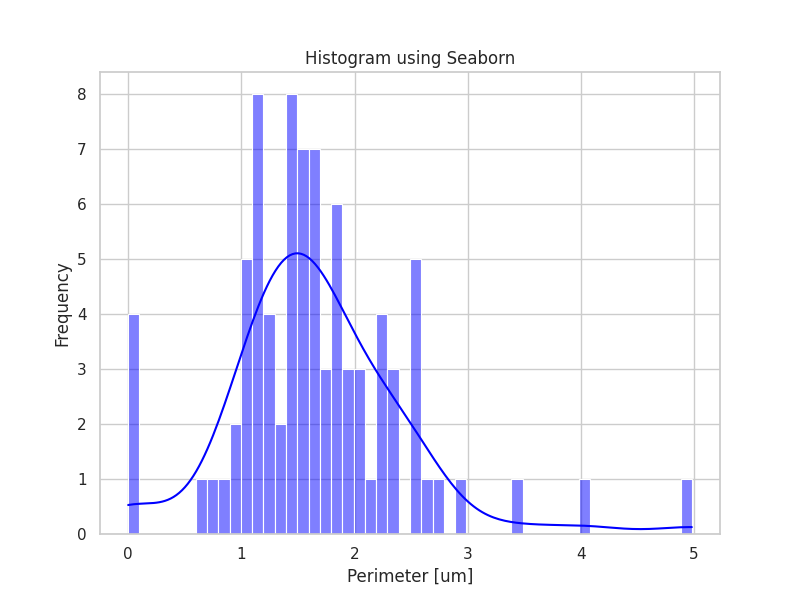

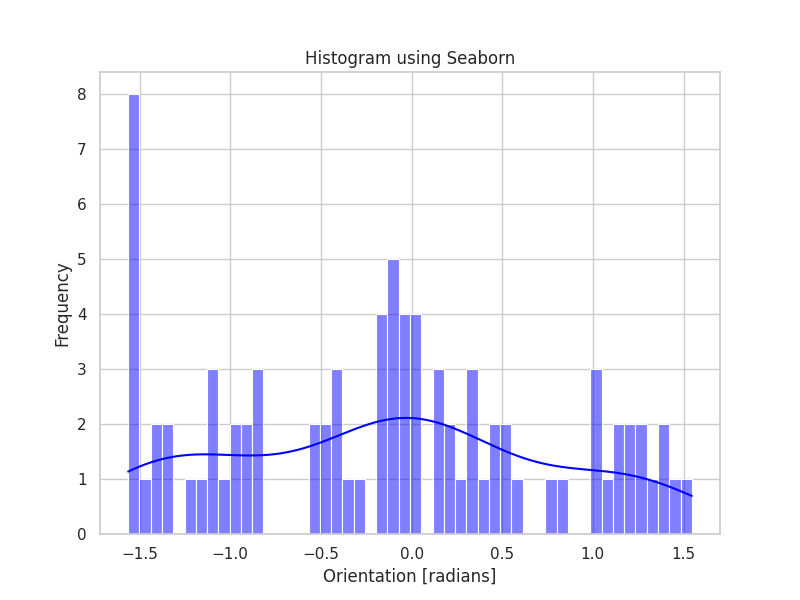

In [39]:
import seaborn as sns

n_of_units = 2 # micron
units_per_pixel = n_of_units/500 # length of scale bar in pixels

props = regionprops_table(labels.astype('int'), intensity_image = big_im, properties =\
        ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length', 
         'orientation', 'perimeter', 'max_intensity', 'mean_intensity', 'min_intensity'))
grain_data = pd.DataFrame(props)

grain_data['major_axis_length'] = grain_data['major_axis_length'].values*units_per_pixel
grain_data['minor_axis_length'] = grain_data['minor_axis_length'].values*units_per_pixel
grain_data['perimeter'] = grain_data['perimeter'].values*units_per_pixel
grain_data['area'] = grain_data['area'].values*units_per_pixel**2

display(grain_data)

# Create a histogram using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(grain_data['area'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel('Area [um^2]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(grain_data['perimeter'], bins=50, kde=True, color='blue')

# Add labels and title
plt.xlabel('Perimeter [um]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(grain_data['orientation'], bins=50, kde=True, color='blue')

# Add labels and title
plt.xlabel('Orientation [radians]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

grain_data.to_csv('/groups/aprintz/github/segmenteverygrain/perovskite_sems/og/Pristine_MAPbI3_0cyc_q001.csv')

## Get grain size distribution

Run this cell and then click (left mouse button) on one end of the scale bar in the image and click (right mouse button) on the other end of the scale bar:

In [15]:
cid5 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.click_for_scale(event, ax))

Use the length of the scale bar in pixels (it should be printed above) to get the scale of the image (in units / pixel):

In [16]:
# n_of_units = 2 # centimeters in the case of 'IMG_5208_image.png'
# units_per_pixel = n_of_units/500 # length of scale bar in pixels

In [17]:
# props = regionprops_table(labels.astype('int'), intensity_image = big_im, properties =\
#         ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length', 
#          'orientation', 'perimeter', 'max_intensity', 'mean_intensity', 'min_intensity'))
# grain_data = pd.DataFrame(props)
# grain_data['major_axis_length'] = grain_data['major_axis_length'].values*units_per_pixel
# grain_data['minor_axis_length'] = grain_data['minor_axis_length'].values*units_per_pixel
# grain_data['perimeter'] = grain_data['perimeter'].values*units_per_pixel
# grain_data['area'] = grain_data['area'].values*units_per_pixel**2

In [18]:
grain_data.head()

label      area  centroid-0  centroid-1  major_axis_length  \
0      1  0.373616  391.963214   75.193097           0.879132   
1      2  0.271600  295.935258  867.378616           0.617328   
2      3  0.424912  758.034153   61.212901           0.989097   
3      4  0.080880  913.313155   28.085856           0.389286   
4      5  0.125056  634.170164  991.827277           0.483616   

   minor_axis_length  orientation  perimeter  max_intensity-0  \
0           0.570593     0.113984   3.560106            233.0   
1           0.588864     0.667493   2.064861            189.0   
2           0.558041    -0.063365   2.681097            195.0   
3           0.279770    -0.013539   1.155813            193.0   
4           0.340896     0.505152   1.424528            183.0   

   max_intensity-1  max_intensity-2  mean_intensity-0  mean_intensity-1  \
0            233.0            233.0         99.644384         99.644384   
1            189.0            189.0        104.579853        104.579853   
2            195.0            195.0        101.368152        101.368152   
3            193.0            193.0        101.834619        101.834619   
4            183.0            183.0         96.969422         96.969422   

   mean_intensity-2  min_intensity-0  min_intensity-1  min_intensity-2  
0         99.644384             14.0             14.0             14.0  
1        104.579853             31.0             31.0             31.0  
2        101.368152             20.0             20.0             20.0  
3        101.834619             13.0             13.0             13.0  
4         96.969422             24.0             24.0             24.0

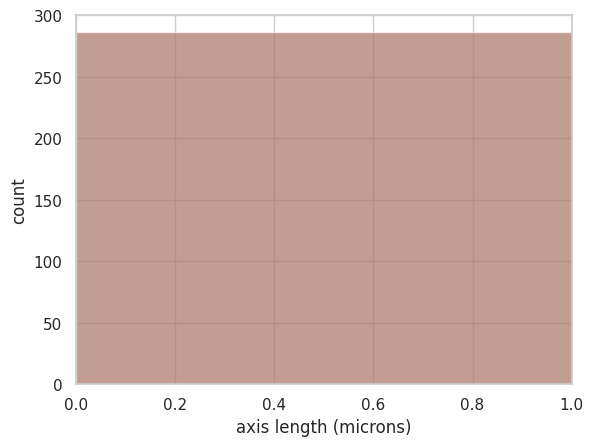

In [ ]:
plt.figure()
plt.hist(grain_data['major_axis_length'], np.arange(0, 200, 5), alpha=0.5)
plt.hist(grain_data['minor_axis_length'], np.arange(0, 200, 5), alpha=0.5)

plt.xlabel('axis length (microns)')
plt.xlim(0, 1)
plt.ylabel('count');

## Save mask and grain labels to PNG files

In [ ]:
dirname = '/Users/zoltan/Dropbox/Segmentation/images/'
# write grayscale mask to PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_mask.png', mask_all)
# Save the image as a PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_image.png', cv2.cvtColor(big_im, cv2.COLOR_BGR2RGB))

False